In [1]:
import logging

In [2]:
# Desativa mensagem constante dos dispositivos disponíveis para treino de modelos
class IgnorePLFilter(logging.Filter):
    def filter(self, record):
        keywords = ['available:', 'CUDA', 'LOCAL_RANK:']
        return not any(keyword in record.getMessage() for keyword in keywords)
    
logging.getLogger('pytorch_lightning.utilities.rank_zero').addFilter(IgnorePLFilter())
logging.getLogger('pytorch_lightning.accelerators.cuda').addFilter(IgnorePLFilter())

In [3]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [4]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

In [5]:
os.environ['OMP_NUM_THREADS'] = '1'

In [6]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape, smape, rmse, r2_score
from sklearn.preprocessing import MaxAbsScaler
from darts.dataprocessing.transformers import Scaler

In [7]:
import seaborn as sns

In [8]:
import optuna

In [9]:
# Inicializa ficheiro de armazenamento de trials do Optuna
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

# Inicialização das Séries

In [10]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [11]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [12]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series, observation_end='2025-04-30').rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [13]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [14]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [15]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [16]:
data_ts = [TimeSeries.from_series(series) for series in data]

In [17]:
[print(f"{idx} {series.title} {len(data_ts[idx])}") for idx, series in enumerate(fred_series_metadata)]
print(f"{len(data_ts) - 1} UK_Daily_Policy_Data {len(data_ts[5])}")

0 Job Postings on Indeed in the United Kingdom 1916
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom 783
2 Residential Property Prices for United Kingdom 227
3 Gross Domestic Product for United Kingdom 280
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom 842
5 UK_Daily_Policy_Data 8886


In [18]:
series_names = ["Job_Postings", "Interest_Rates", "Residential_Property_Prices", "GDP", "CPI", "Economic_Uncertainty"]

Escolha da série temporal a modelar:

In [19]:
series_chosen = 0
series = data_ts[series_chosen]
series_name = series_names[series_chosen]

Escolha das métricas a avaliar, incluindo seleção de uma principal para otimização de hiperparâmetros.

In [20]:
metrics = [smape, r2_score]
main_metric = metrics[0]
assert main_metric in metrics

In [21]:
splitting = 0.9
visualizing = 0.7

In [22]:
train, test = series.split_before(splitting)
train, val = train.split_before(splitting)

Scaling das séries temporais para treino das redes neuronais.

In [23]:
scaler = MaxAbsScaler()
transformer = Scaler(scaler)

In [24]:
train = transformer.fit_transform(train)
val = transformer.transform(val)
test = transformer.transform(test)

# Modelação de Time Series com Redes Neuronais

O pacote *darts* possibilita o uso de várias arquiteturas de redes neuronais para modelação de séries temporais. Para a construção e treino das redes, utiliza como backend o pacote pytorch-lightning, um framework para pytorch.

Utilizamos uma GPU para treinar os nossos modelos localmente. 

In [25]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
torch.set_float32_matmul_precision('high')

NVIDIA GeForce RTX 5070 Ti


In [26]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback

In [27]:
# Criacao de um callback de logging dos losses de treino e validacao
class LossRecorder(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())


In [28]:
loss_recorder = LossRecorder()
# stop training when validation loss does not decrease more than 0.00001 (`min_delta`) 
# over a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [29]:
from darts.models import RNNModel, BlockRNNModel

### Treino de LSTM

Construção da primeira rede neuronal com hiperparâmetros default.

In [30]:
lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=3,
    dropout=0,
    batch_size=64,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM",
    log_tensorboard=True,
    random_state=7,
    training_length=int(len(val)/2),     # Estes hiperparametros sao um fator da dimensao da serie a ser modelada
    input_chunk_length=int(len(val)/4),  # para garantir inputs de dimensao adequada
    # output_chunk_length=12,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs,
)


In [31]:
# Treino do modelo com validacao
lstm_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.6 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=87, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=43, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002B0352F7580>, <__main__.LossRecorder object at 0x000002B0352F7880>]})

O modelo apresenta uma aprendizagem adequada ao longo das épocas de treino.

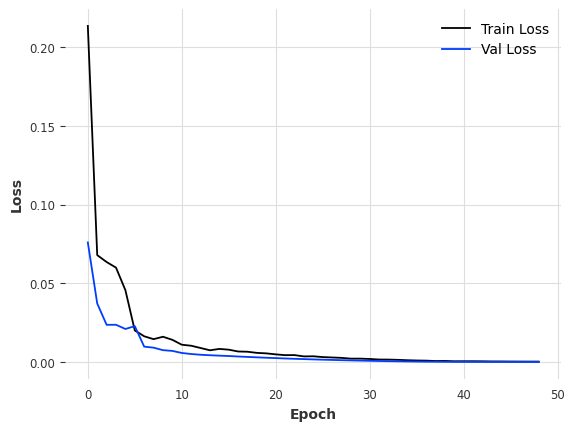

In [32]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
lstm_model.load_from_checkpoint("LSTM", best=True)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=87, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=43, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002B0482A98D0>, <__main__.LossRecorder object at 0x000002B0482A9C30>]})

In [34]:
val_preds = transformer.inverse_transform(lstm_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

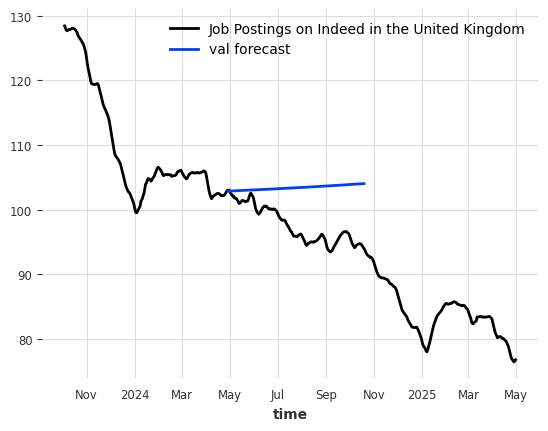

In [35]:
series.drop_before(visualizing).plot()
val_preds.plot(label="val forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

O modelo 

### Treino de NBEATS

Como experiência, treinamos também uma arquitetura de redes neuronais mais

In [36]:
loss_recorder = LossRecorder()

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [37]:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html
from darts.models import NBEATSModel
nbeats_model = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12, 
    batch_size=64,
    n_epochs=100, 
    random_state=7, 
    optimizer_kwargs={"lr": 1e-4},
    model_name="NBEATS",
    log_tensorboard=True,
    pl_trainer_kwargs=pl_trainer_kwargs
)
nbeats_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, batch_size=64, n_epochs=100, random_state=7, optimizer_kwargs={'lr': 0.0001}, model_name=NBEATS, log_tensorboard=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002B04803A470>, <__main__.LossRecorder object at 0x000002B04803A350>]})

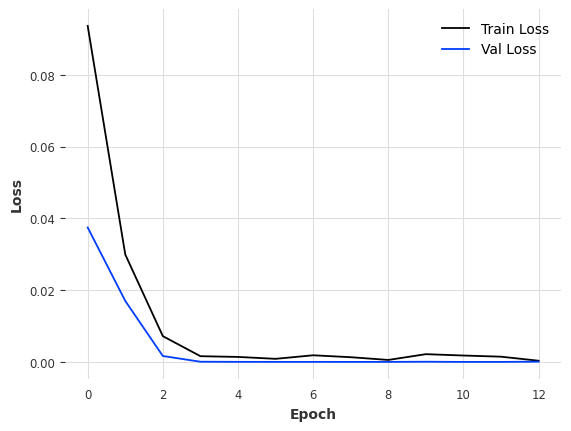

In [38]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
len(val)

174

In [40]:
val_preds = transformer.inverse_transform(nbeats_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

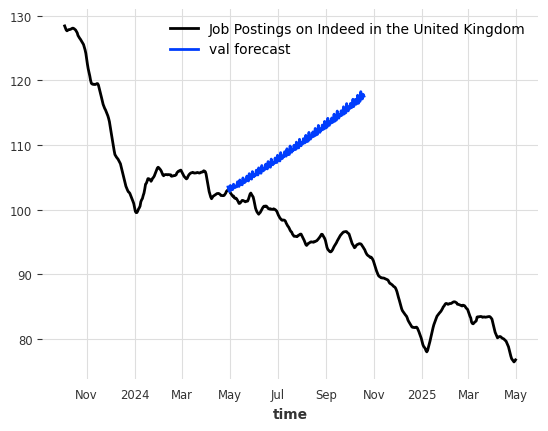

In [41]:
series.drop_before(visualizing).plot()
val_preds.plot(label="val forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

# Backtesting NNs

In [42]:
from darts.models import NaiveSeasonal

In [43]:
base_model = NaiveSeasonal(K=1)

In [44]:
base_model.model_name = "Baseline"

In [45]:
def backtest_models(
    series: TimeSeries, 
    models: list, 
    horizons: list=[1, 3, 7], 
    points_to_test: int=len(test), 
    verbose=True, retrain=False, baseline=base_model, metrics=metrics
):
    backtest_results = dict()
    if baseline:
        models = [baseline, *models]
    for horizon in sorted(horizons):
        print(f"Backtesting {horizon} {series.freq} horizon")
        backtests = []
        for model in models:
            if model.model_name == "Baseline":
                backtest = model.historical_forecasts(
                    transformer.transform(series),
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=True,
                    verbose=False,
                )
            else:
                print(f"Backtesting {model.model_name}")
                backtest = model.historical_forecasts(
                    transformer.transform(series),
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=retrain,
                    verbose=verbose,
                )
            backtest = transformer.inverse_transform(backtest)
            backtests.append(backtest)
        backtest_results[horizon] = {
            str(model.model_name): (backtests[i], {metric.__name__: round(metric(series, backtests[i]), 3) for metric in metrics}) 
            for i, model in enumerate(models)
        }
    return backtest_results

In [46]:
def plot_backtest_results(
    series: TimeSeries, 
    backtest_results: dict, 
    points_to_test: int=len(test),
):
    for horizon, model in backtest_results.items():
        plt.figure(figsize=(12, 6))
        series.drop_before(int(len(series) - 1.5*points_to_test)).plot(label='data')
        for model_name, (backtest, metrics) in model.items():
            backtest.plot(lw=3, label=f'{model_name}, {metrics}')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.legend()
        plt.show()

In [47]:
models = [nbeats_model, lstm_model]

In [48]:
results = backtest_models(
    series, 
    models=models, 
    metrics=metrics,
    points_to_test=len(test)
)

Backtesting 1 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

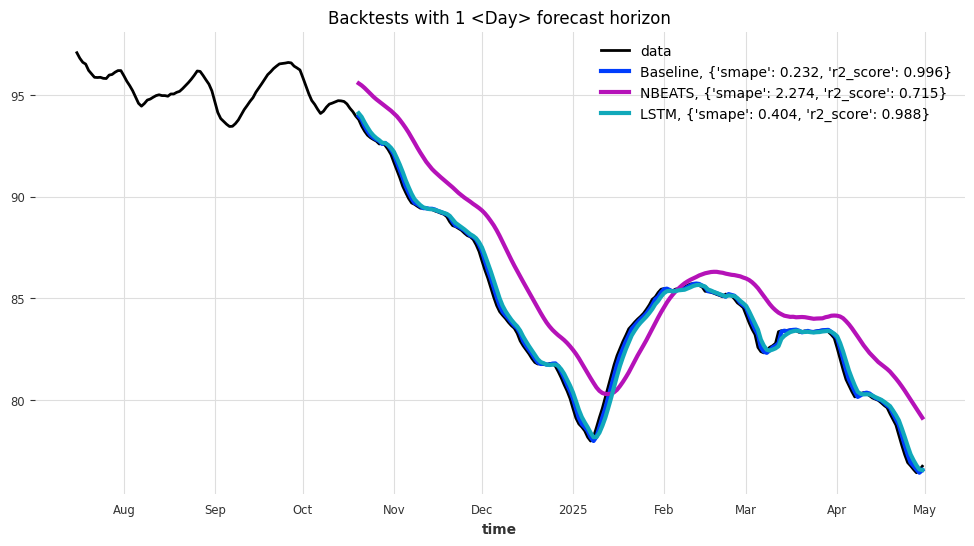

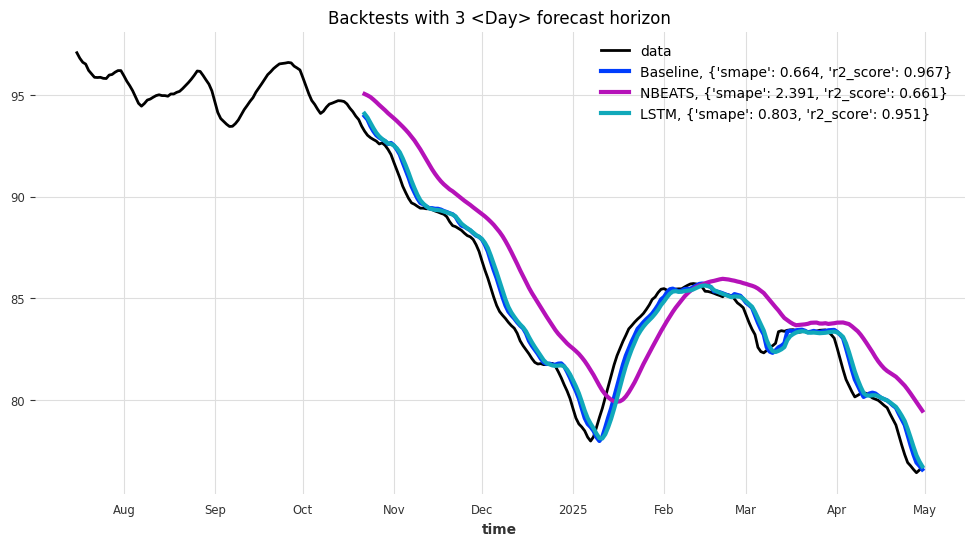

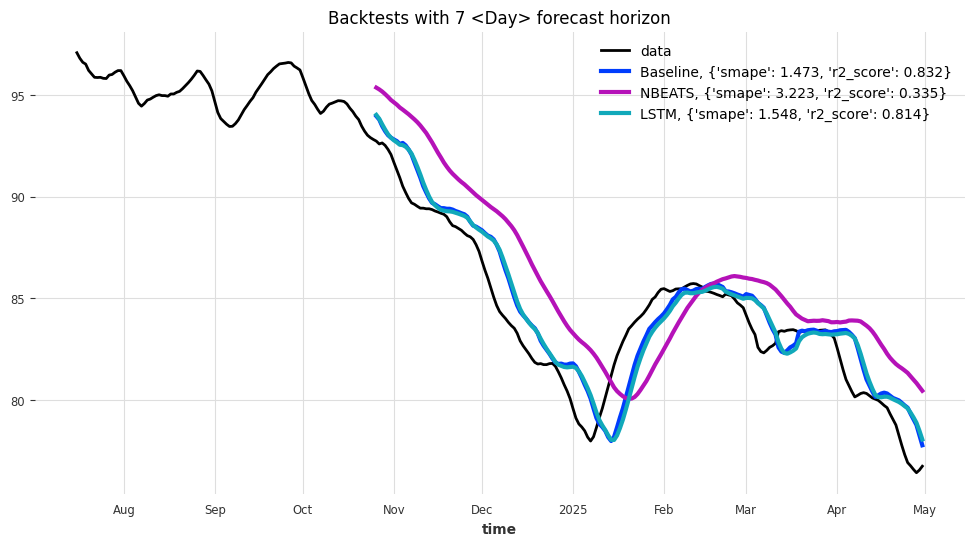

In [49]:
plot_backtest_results(series, results, points_to_test=len(test))

In [50]:
import optuna

In [51]:
def train_RNN(params):
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.05,
        mode='min',
    )
    pl_trainer_kwargs={"callbacks": [early_stopper]}
    
    model = RNNModel(
        **params,
        n_epochs=100,
        model_name=params["model"],
        log_tensorboard=True,
        random_state=7,
        training_length=int(len(val)/2),
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs=pl_trainer_kwargs,
    )
    model.fit(train, val_series=val, verbose=False)
    model.load_from_checkpoint(params["model"], best=True)
    return model

In [52]:
def optimize_RNN(trial: optuna.Trial):
    params = {
        "model": trial.suggest_categorical("model", ["RNN", "GRU", "LSTM"]),
        "hidden_dim": trial.suggest_int("hidden_dim", 2, 50),
        "n_rnn_layers": trial.suggest_int("n_rnn_layers", 1, 5),
        "dropout": trial.suggest_float("dropout", 0, 0.3),
        "batch_size": 2 ** trial.suggest_int("log2(batch_size)", 4, 8),  # will be a power of two
        "input_chunk_length": trial.suggest_int("input_chunk_length", 1, int(len(val)/4)),
        "optimizer_kwargs": {
            "lr": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        }
    }
    if params["n_rnn_layers"] == 1:
        params["dropout"] = 0
        
    trial.set_user_attr("model_params", params)
    
    model = train_RNN(params)
    backtests = backtest_models(
        series[train.time_index.union(val.time_index)], 
        models=[model], 
        horizons=[1, 2, 3, 5, 7],
        metrics=metrics,
        points_to_test=len(val),
    )
    results = [model_dict[params["model"]][1][main_metric.__name__]/(horizon**0.5) 
               for horizon, model_dict in backtests.items()]
    
    return sum(results) / len(results)

In [53]:
# Create optuna study with defined function and storage
study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name=f"{series_name}_{main_metric.__name__}_avghorizons_RNNfamily_study",
    load_if_exists=True
)

[I 2025-05-14 23:59:45,246] Using an existing study with name 'Job_Postings_smape_avghorizons_RNNfamily_study' instead of creating a new one.


In [54]:
# Optimize for n_trials, using one thread, timeout of 5 min
study.optimize(optimize_RNN, n_trials=1, n_jobs=1)  # , timeout=30)

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-14 23:59:50,416] Trial 300 finished with value: 0.29796187807623964 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'dropout': 0.00853821050297007, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.03666938807686907}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-14 23:59:55,587] Trial 301 finished with value: 0.39041595994248796 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'dropout': 0.0017192241920969131, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.047496063815726325}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:00,772] Trial 302 finished with value: 0.44245990673028607 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'dropout': 0.00691319098837186, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.008036349946356167}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:06,846] Trial 303 finished with value: 11.285848152659018 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'dropout': 0.008816614201840151, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.00033545283895290484}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:11,968] Trial 304 finished with value: 0.48814838915051945 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'dropout': 0.013366067489941458, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.03755492229657053}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:17,207] Trial 305 finished with value: 0.5531943492182194 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'dropout': 0.24360763362065752, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.06226212192106855}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:22,301] Trial 306 finished with value: 1.5446189089985762 and parameters: {'model': 'RNN', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.022347314079700833, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.035007246574648536}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:27,567] Trial 307 finished with value: 0.3418183231341786 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'dropout': 0.017026956145209632, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.04920205863622654}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:33,034] Trial 308 finished with value: 2.443829536229887 and parameters: {'model': 'LSTM', 'hidden_dim': 43, 'n_rnn_layers': 1, 'dropout': 0.025781580719224352, 'log2(batch_size)': 6, 'input_chunk_length': 28, 'learning_rate': 0.018343916691186315}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:38,583] Trial 309 finished with value: 0.6382528426477415 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'dropout': 0.0012221821115496086, 'log2(batch_size)': 6, 'input_chunk_length': 26, 'learning_rate': 0.04138609500536602}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:43,782] Trial 310 finished with value: 0.5906117815595283 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'dropout': 0.11117090979437469, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.02346755924668508}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:48,346] Trial 311 finished with value: 11.436825938590164 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'dropout': 0.02933898506947328, 'log2(batch_size)': 8, 'input_chunk_length': 38, 'learning_rate': 0.02940005381010643}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:53,512] Trial 312 finished with value: 0.5744775321705589 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'dropout': 0.00913429249926034, 'log2(batch_size)': 6, 'input_chunk_length': 27, 'learning_rate': 0.02071021739702172}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:00:58,840] Trial 313 finished with value: 1.0067940598868206 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.01958590990156362, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.013181007787485311}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:01:04,144] Trial 314 finished with value: 0.28038463769629296 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.032946206730697966, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.03203876405647683}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:01:09,588] Trial 315 finished with value: 0.46128564116359405 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'dropout': 0.03328774840115462, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.03356983399697443}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:01:15,194] Trial 316 finished with value: 0.3878774658184362 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 2, 'dropout': 0.024465751140131234, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.03926227033694929}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:01:20,436] Trial 317 finished with value: 0.3943144023553381 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'dropout': 0.01582152662740225, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.02842916352493261}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:01:27,748] Trial 318 finished with value: 22.307193066702176 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 5, 'dropout': 0.03722867842460456, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.0526945686961865}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:01:32,929] Trial 319 finished with value: 0.3150360532291435 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'dropout': 0.028382819120669478, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.033732017331616876}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:01:38,460] Trial 320 finished with value: 0.6865972218853793 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.20614935214225363, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.02537072455003282}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:01:43,555] Trial 321 finished with value: 0.30272270005828394 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'dropout': 0.2997991152920829, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.04309705924970631}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:01:48,699] Trial 322 finished with value: 0.3133211068641505 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'dropout': 0.04740116912660329, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.07278307277748473}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:01:53,908] Trial 323 finished with value: 0.3100842156889637 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.021679545701868592, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.029036170689050855}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:01:59,161] Trial 324 finished with value: 0.43052991761727066 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'dropout': 0.009336981211649357, 'log2(batch_size)': 6, 'input_chunk_length': 29, 'learning_rate': 0.02282529773345073}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:02:04,398] Trial 325 finished with value: 0.3023414662086362 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'dropout': 0.03435744636669152, 'log2(batch_size)': 6, 'input_chunk_length': 30, 'learning_rate': 0.03245775040217933}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:02:12,999] Trial 326 finished with value: 11.505163651865908 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'dropout': 0.041279647745950124, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 7.011921397126659e-05}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:02:18,170] Trial 327 finished with value: 0.3425005193123974 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'dropout': 0.02834963921971464, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.026576890384777497}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:02:23,120] Trial 328 finished with value: 0.8946591225996643 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'dropout': 0.017746870059281064, 'log2(batch_size)': 6, 'input_chunk_length': 20, 'learning_rate': 0.017493548889793036}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:02:28,360] Trial 329 finished with value: 0.36780602582380534 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'dropout': 0.03233699463756403, 'log2(batch_size)': 6, 'input_chunk_length': 31, 'learning_rate': 0.035455524870477546}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:02:33,242] Trial 330 finished with value: 1.324059723549718 and parameters: {'model': 'RNN', 'hidden_dim': 41, 'n_rnn_layers': 1, 'dropout': 0.022069567683136695, 'log2(batch_size)': 6, 'input_chunk_length': 7, 'learning_rate': 0.021969316676176857}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:02:38,660] Trial 331 finished with value: 0.6445303320931363 and parameters: {'model': 'LSTM', 'hidden_dim': 43, 'n_rnn_layers': 1, 'dropout': 0.0401439896842618, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.04332300875827573}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:02:44,260] Trial 332 finished with value: 0.5283443346375021 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'dropout': 0.013659372583795293, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.02546271448048059}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:02:50,546] Trial 333 finished with value: 0.3531778562202196 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 3, 'dropout': 0.006104084914345769, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.01865577479930228}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:02:55,822] Trial 334 finished with value: 0.33407254630501526 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'dropout': 0.05028878325866028, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.0310934067081006}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:01,047] Trial 335 finished with value: 0.5461351215092173 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.024840801730454075, 'log2(batch_size)': 6, 'input_chunk_length': 11, 'learning_rate': 0.009723100720355562}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:06,097] Trial 336 finished with value: 0.6263701102924519 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'dropout': 0.035046044617662184, 'log2(batch_size)': 6, 'input_chunk_length': 27, 'learning_rate': 0.03770403614392756}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:11,273] Trial 337 finished with value: 0.339948949237759 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'dropout': 0.18794303657116151, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.05508936855143573}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:16,851] Trial 338 finished with value: 0.29706043436067375 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 1, 'dropout': 0.029560614221793232, 'log2(batch_size)': 6, 'input_chunk_length': 19, 'learning_rate': 0.021768552370699128}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:21,993] Trial 339 finished with value: 0.3759203279428921 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'dropout': 0.027603152501625546, 'log2(batch_size)': 6, 'input_chunk_length': 18, 'learning_rate': 0.004222498099503759}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:27,161] Trial 340 finished with value: 0.29990590971152287 and parameters: {'model': 'GRU', 'hidden_dim': 47, 'n_rnn_layers': 1, 'dropout': 0.015009452423786042, 'log2(batch_size)': 6, 'input_chunk_length': 28, 'learning_rate': 0.023104072497344457}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:32,422] Trial 341 finished with value: 0.7032932472380505 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 1, 'dropout': 0.044550294239890494, 'log2(batch_size)': 6, 'input_chunk_length': 18, 'learning_rate': 0.030413977876304905}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:37,806] Trial 342 finished with value: 0.30775339666540863 and parameters: {'model': 'GRU', 'hidden_dim': 48, 'n_rnn_layers': 1, 'dropout': 0.020689200303311887, 'log2(batch_size)': 6, 'input_chunk_length': 19, 'learning_rate': 0.020445276883212182}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:42,982] Trial 343 finished with value: 0.30365596456224475 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'dropout': 0.036495349536094124, 'log2(batch_size)': 6, 'input_chunk_length': 20, 'learning_rate': 0.027627959203788313}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:48,581] Trial 344 finished with value: 0.38437837893629573 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 1, 'dropout': 0.029028681028148224, 'log2(batch_size)': 6, 'input_chunk_length': 19, 'learning_rate': 0.024738401671189344}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:53,603] Trial 345 finished with value: 0.3230980143132932 and parameters: {'model': 'GRU', 'hidden_dim': 21, 'n_rnn_layers': 1, 'dropout': 0.02264180177691532, 'log2(batch_size)': 6, 'input_chunk_length': 26, 'learning_rate': 0.03898974334569197}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:03:58,872] Trial 346 finished with value: 0.419692347577392 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.0002963181121501072, 'log2(batch_size)': 6, 'input_chunk_length': 17, 'learning_rate': 0.020483137549242386}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:04:04,335] Trial 347 finished with value: 0.3233770994999695 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'dropout': 0.04147207614035345, 'log2(batch_size)': 6, 'input_chunk_length': 34, 'learning_rate': 0.03409308689076231}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:04:09,668] Trial 348 finished with value: 0.4085175033881857 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'dropout': 0.010128865536356804, 'log2(batch_size)': 6, 'input_chunk_length': 26, 'learning_rate': 0.04741137291524751}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:04:14,872] Trial 349 finished with value: 0.33445654055865726 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'dropout': 0.016889483749063846, 'log2(batch_size)': 6, 'input_chunk_length': 18, 'learning_rate': 0.0167081250532745}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:04:20,478] Trial 350 finished with value: 0.5075452145563397 and parameters: {'model': 'GRU', 'hidden_dim': 49, 'n_rnn_layers': 1, 'dropout': 0.03174175122969104, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.026447912444093235}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:04:25,453] Trial 351 finished with value: 7.796409960371494 and parameters: {'model': 'RNN', 'hidden_dim': 43, 'n_rnn_layers': 1, 'dropout': 0.025361377545491275, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.029737633049753846}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:04:31,132] Trial 352 finished with value: 0.6875580881422929 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 2, 'dropout': 0.037091047340782606, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.02307484100924192}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:04:36,429] Trial 353 finished with value: 0.4779701892524571 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 1, 'dropout': 0.08634114783734552, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.01921675419255818}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:04:41,623] Trial 354 finished with value: 2.810578207829586 and parameters: {'model': 'LSTM', 'hidden_dim': 16, 'n_rnn_layers': 1, 'dropout': 0.03088699609051795, 'log2(batch_size)': 6, 'input_chunk_length': 20, 'learning_rate': 0.040040848073290065}. Best is trial 183 with value: 0.27386544477299785.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:04:46,853] Trial 355 finished with value: 0.2697567455387323 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.046623085954867846, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.03260032033007164}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:04:52,410] Trial 356 finished with value: 87.86216317712154 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'dropout': 0.06178742901180638, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 1.1024439749531013e-05}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:04:57,689] Trial 357 finished with value: 0.45949770133324064 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.046063390778778364, 'log2(batch_size)': 6, 'input_chunk_length': 34, 'learning_rate': 0.026813419468859193}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:05:02,906] Trial 358 finished with value: 0.9061567993464834 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.0528616003266273, 'log2(batch_size)': 6, 'input_chunk_length': 25, 'learning_rate': 0.01670653861359279}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:05:08,014] Trial 359 finished with value: 0.38404506461819554 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'dropout': 0.042760638562320354, 'log2(batch_size)': 6, 'input_chunk_length': 27, 'learning_rate': 0.022649130019409228}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:05:13,482] Trial 360 finished with value: 0.2938669884497433 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.051215827207477534, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.031272809827476246}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:05:18,690] Trial 361 finished with value: 0.32115436796825103 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'dropout': 0.05805220737612349, 'log2(batch_size)': 6, 'input_chunk_length': 34, 'learning_rate': 0.03101819972448426}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:05:24,195] Trial 362 finished with value: 0.29526202828650117 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.05216529490079387, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.032680414225792404}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:05:33,190] Trial 363 finished with value: 6.292381379542139 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 4, 'dropout': 0.054622422732062616, 'log2(batch_size)': 5, 'input_chunk_length': 36, 'learning_rate': 0.04522173689185323}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:05:38,297] Trial 364 finished with value: 0.32066827783170326 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'dropout': 0.06854339840652444, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.03444301727124108}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:05:48,591] Trial 365 finished with value: 4.8567687960258095 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'dropout': 0.056858442791721864, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 2.914267687212719e-05}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:05:53,767] Trial 366 finished with value: 0.28559908512425125 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.04895565173530797, 'log2(batch_size)': 6, 'input_chunk_length': 33, 'learning_rate': 0.033249016262613174}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:05:59,036] Trial 367 finished with value: 0.4012988964350985 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.06118844691178031, 'log2(batch_size)': 6, 'input_chunk_length': 33, 'learning_rate': 0.062064108120174356}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:06:05,788] Trial 368 finished with value: 1.036228242300052 and parameters: {'model': 'GRU', 'hidden_dim': 10, 'n_rnn_layers': 3, 'dropout': 0.0511041478073481, 'log2(batch_size)': 6, 'input_chunk_length': 32, 'learning_rate': 0.04318623364406126}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:06:10,954] Trial 369 finished with value: 0.2847926155056622 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.051544021505151146, 'log2(batch_size)': 6, 'input_chunk_length': 34, 'learning_rate': 0.03402769874331271}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:06:16,067] Trial 370 finished with value: 0.3952024022246456 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'dropout': 0.06491362393574138, 'log2(batch_size)': 6, 'input_chunk_length': 34, 'learning_rate': 0.03472056223592551}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:06:21,341] Trial 371 finished with value: 0.45671209339788277 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.05065950405490963, 'log2(batch_size)': 6, 'input_chunk_length': 33, 'learning_rate': 0.046980761457665644}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:06:26,471] Trial 372 finished with value: 0.29719780620873165 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.05029810640691338, 'log2(batch_size)': 6, 'input_chunk_length': 32, 'learning_rate': 0.03349406473831391}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:06:31,666] Trial 373 finished with value: 0.5921429418277545 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'dropout': 0.058999621592444346, 'log2(batch_size)': 6, 'input_chunk_length': 33, 'learning_rate': 0.039503049651277725}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:06:37,033] Trial 374 finished with value: 0.3283336306587493 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'dropout': 0.051672144478046855, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.03169830011246982}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:06:41,946] Trial 375 finished with value: 7.401763685954146 and parameters: {'model': 'RNN', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.04657289723603039, 'log2(batch_size)': 6, 'input_chunk_length': 34, 'learning_rate': 0.038166012227279784}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:06:47,114] Trial 376 finished with value: 0.3236739818569577 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'dropout': 0.07290853519786095, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.04950316297775876}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:06:52,032] Trial 377 finished with value: 0.3327823096640264 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'dropout': 0.04581293057202375, 'log2(batch_size)': 6, 'input_chunk_length': 32, 'learning_rate': 0.02913981379307834}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:06:57,062] Trial 378 finished with value: 0.539545802876267 and parameters: {'model': 'LSTM', 'hidden_dim': 24, 'n_rnn_layers': 1, 'dropout': 0.06263229115177185, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.05228746860009048}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:07:02,037] Trial 379 finished with value: 0.676853782101151 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'dropout': 0.05264525402299996, 'log2(batch_size)': 6, 'input_chunk_length': 34, 'learning_rate': 0.028874159280759565}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:07:07,232] Trial 380 finished with value: 0.4910312591727187 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'dropout': 0.04647936511258805, 'log2(batch_size)': 6, 'input_chunk_length': 34, 'learning_rate': 0.03900005184431226}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:07:12,254] Trial 381 finished with value: 0.30864363337414036 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'dropout': 0.0447771497719786, 'log2(batch_size)': 6, 'input_chunk_length': 30, 'learning_rate': 0.03122879386047271}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:07:17,480] Trial 382 finished with value: 0.32163497418496884 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'dropout': 0.05856595336184938, 'log2(batch_size)': 6, 'input_chunk_length': 31, 'learning_rate': 0.02632598861373162}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:07:23,210] Trial 383 finished with value: 0.4136463054130274 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'dropout': 0.04041614296413054, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.03444781789828644}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:07:29,476] Trial 384 finished with value: 12.56222394713632 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'dropout': 0.05532186406345694, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.00017692214998915495}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:07:34,657] Trial 385 finished with value: 0.4748545971082859 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'dropout': 0.21716560259364104, 'log2(batch_size)': 6, 'input_chunk_length': 33, 'learning_rate': 0.04339850545637016}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:07:40,313] Trial 386 finished with value: 0.2826505087307497 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.04909585741218507, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.026047140056950864}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:07:45,538] Trial 387 finished with value: 0.41486646040547565 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.04998261463644387, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.06175885631751965}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:07:50,775] Trial 388 finished with value: 0.5252895629334777 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 1, 'dropout': 0.06417447382655116, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.032955154434464555}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:07:55,918] Trial 389 finished with value: 0.5955766345774066 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'dropout': 0.05021907064631114, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.0286136567531142}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:08:01,124] Trial 390 finished with value: 0.4358351743058583 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'dropout': 0.043205898488873795, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.04016461346394699}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:08:06,271] Trial 391 finished with value: 0.3182245462181499 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'dropout': 0.282922893320003, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.02537023062106175}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:08:11,768] Trial 392 finished with value: 0.28656556573565617 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.039250031637868464, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.035154449899044884}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:08:16,914] Trial 393 finished with value: 0.3043202246712772 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.041681324284585416, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.04416607984114362}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:08:21,961] Trial 394 finished with value: 0.3422001220598794 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'dropout': 0.047816287157533124, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.05706909144567629}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:08:27,142] Trial 395 finished with value: 0.30900464129674265 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'dropout': 0.056208658045130075, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.03575063622146524}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:08:32,197] Trial 396 finished with value: 0.2949768841365195 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'dropout': 0.0390766796214561, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.03183561301081888}. Best is trial 355 with value: 0.2697567455387323.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:08:37,384] Trial 397 finished with value: 0.26777949318670385 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.040956110606969194, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.03654016499126448}. Best is trial 397 with value: 0.26777949318670385.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:08:42,911] Trial 398 finished with value: 0.3367992361673934 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.04074173334761488, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.04619211830261777}. Best is trial 397 with value: 0.26777949318670385.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 00:08:48,039] Trial 399 finished with value: 0.2648762954237142 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.03921231198103676, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.036638281914884274}. Best is trial 399 with value: 0.2648762954237142.


In [55]:
study_df = study.trials_dataframe()
study_df["duration"] = study_df["duration"].dt.total_seconds()

In [56]:
study_df.head(1)

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_hidden_dim,params_input_chunk_length,params_learning_rate,params_log2(batch_size),params_model,params_n_rnn_layers,user_attrs_model_params,state
0,0,1.000061,2025-05-14 21:36:27.556996,2025-05-14 21:36:39.057026,11.50003,0.010205,15,31,0.084433,4,LSTM,3,"{'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_lay...",COMPLETE


In [57]:
study_grouped = study_df.groupby("params_model").agg({
    "value": ["count", "mean", "min", "max", "idxmin"],
    "duration": ["mean", "min", "max"],  
})
study_grouped

value                                          duration  \
             count       mean       min         max idxmin      mean   
params_model                                                           
GRU            355   1.591761  0.264876   87.862163    399  5.625804   
LSTM            23  11.537070  0.539546  123.480753    378  6.637079   
RNN             22   5.400624  0.598870   26.812111    261  6.078485   

                                   
                   min        max  
params_model                       
GRU           4.302156  13.650981  
LSTM          5.020001  11.997386  
RNN           4.497051  15.066079

In [58]:
best_models = [train_RNN(
    params
) for params in study_df.loc[study_grouped[("value", "idxmin")]]["user_attrs_model_params"]]


C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


In [59]:
results = backtest_models(
    series, 
    models=best_models, 
    horizons=[1, 2, 3, 5, 7, 15, 30], 
    metrics=metrics,
    points_to_test=len(test)
)


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

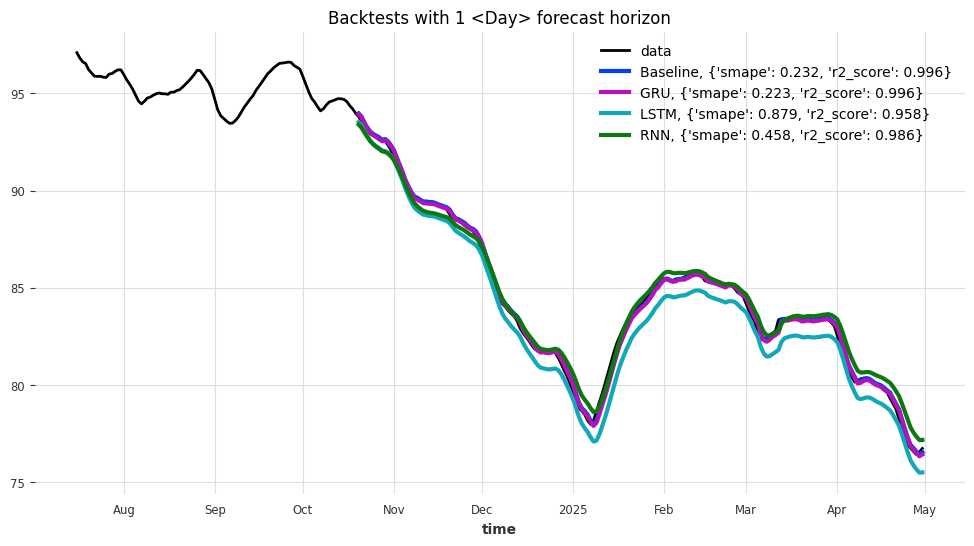

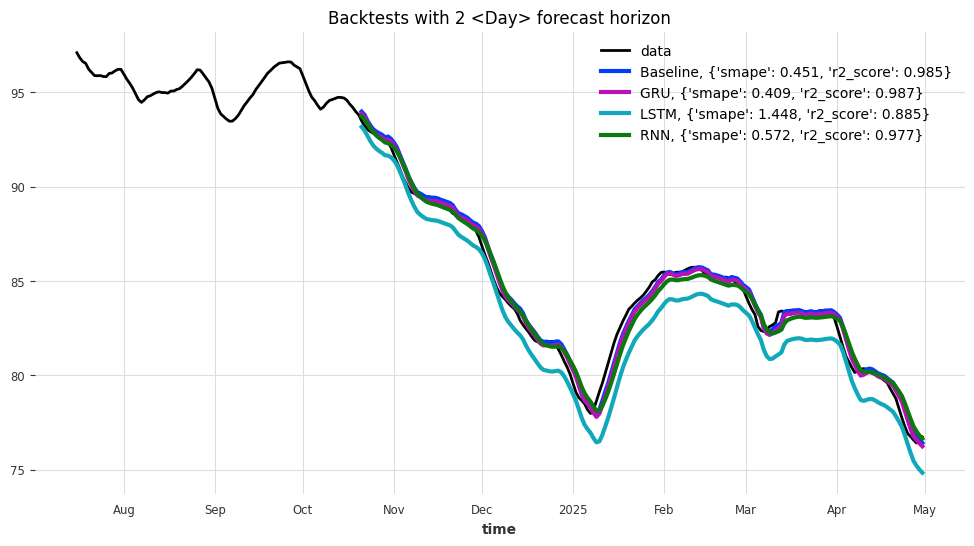

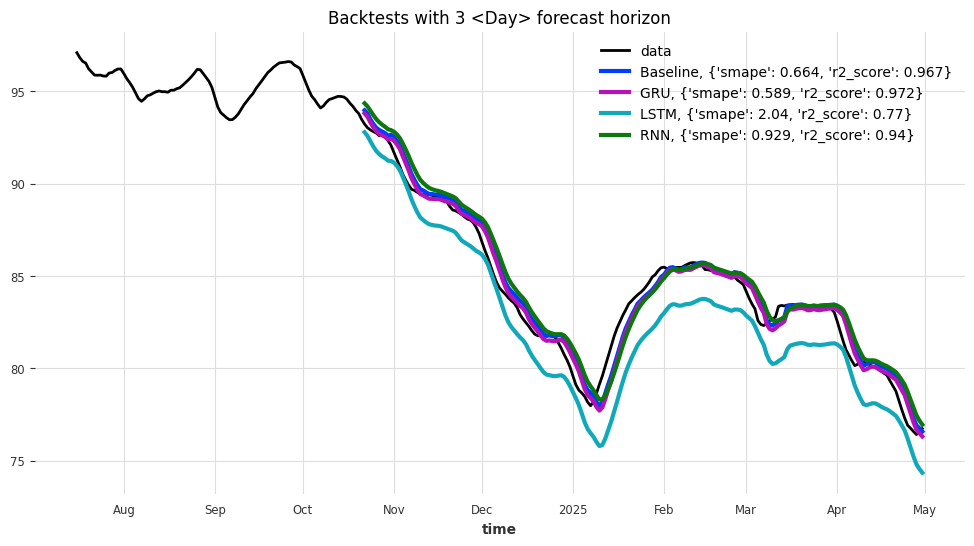

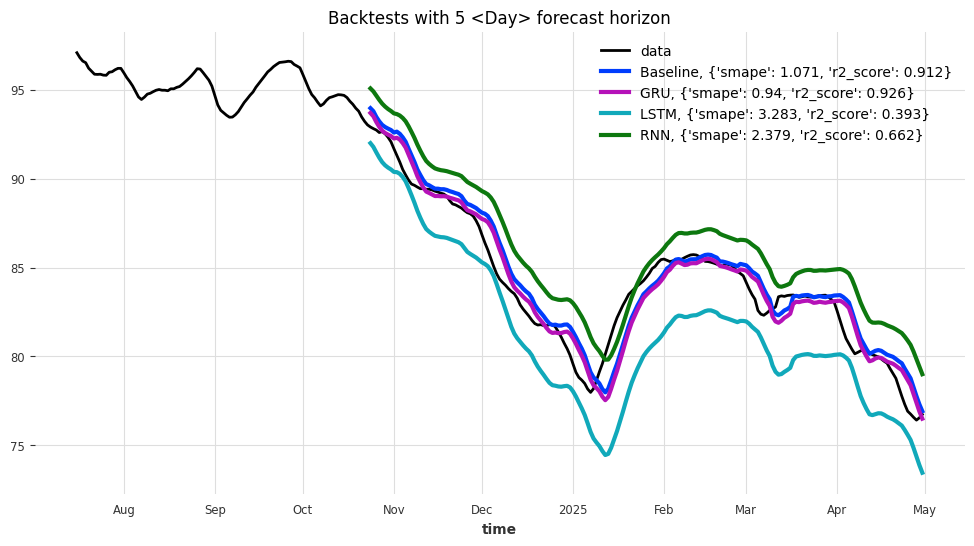

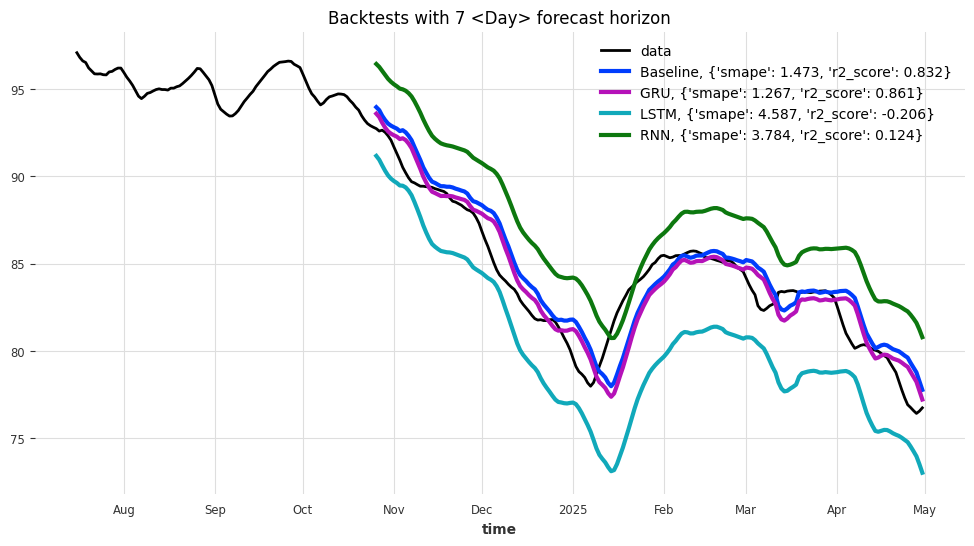

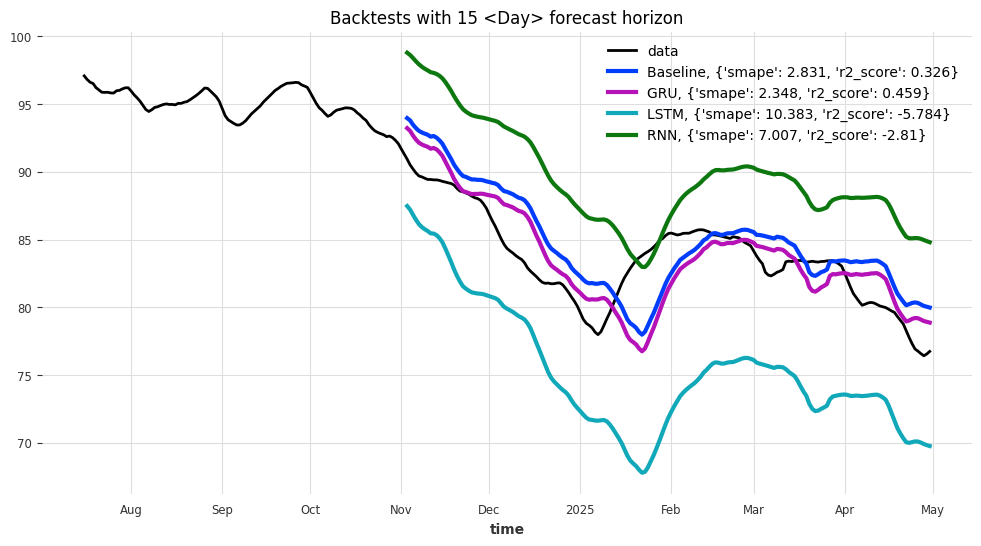

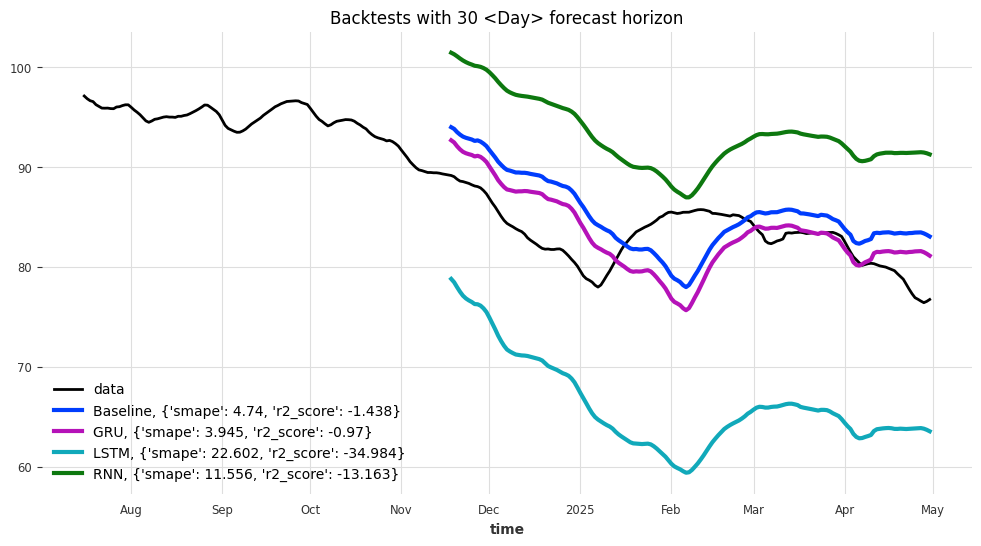

In [60]:
plot_backtest_results(
    series, 
    results, 
    points_to_test=len(test)
)


### Comparação da otimização dos modelos da família RNN

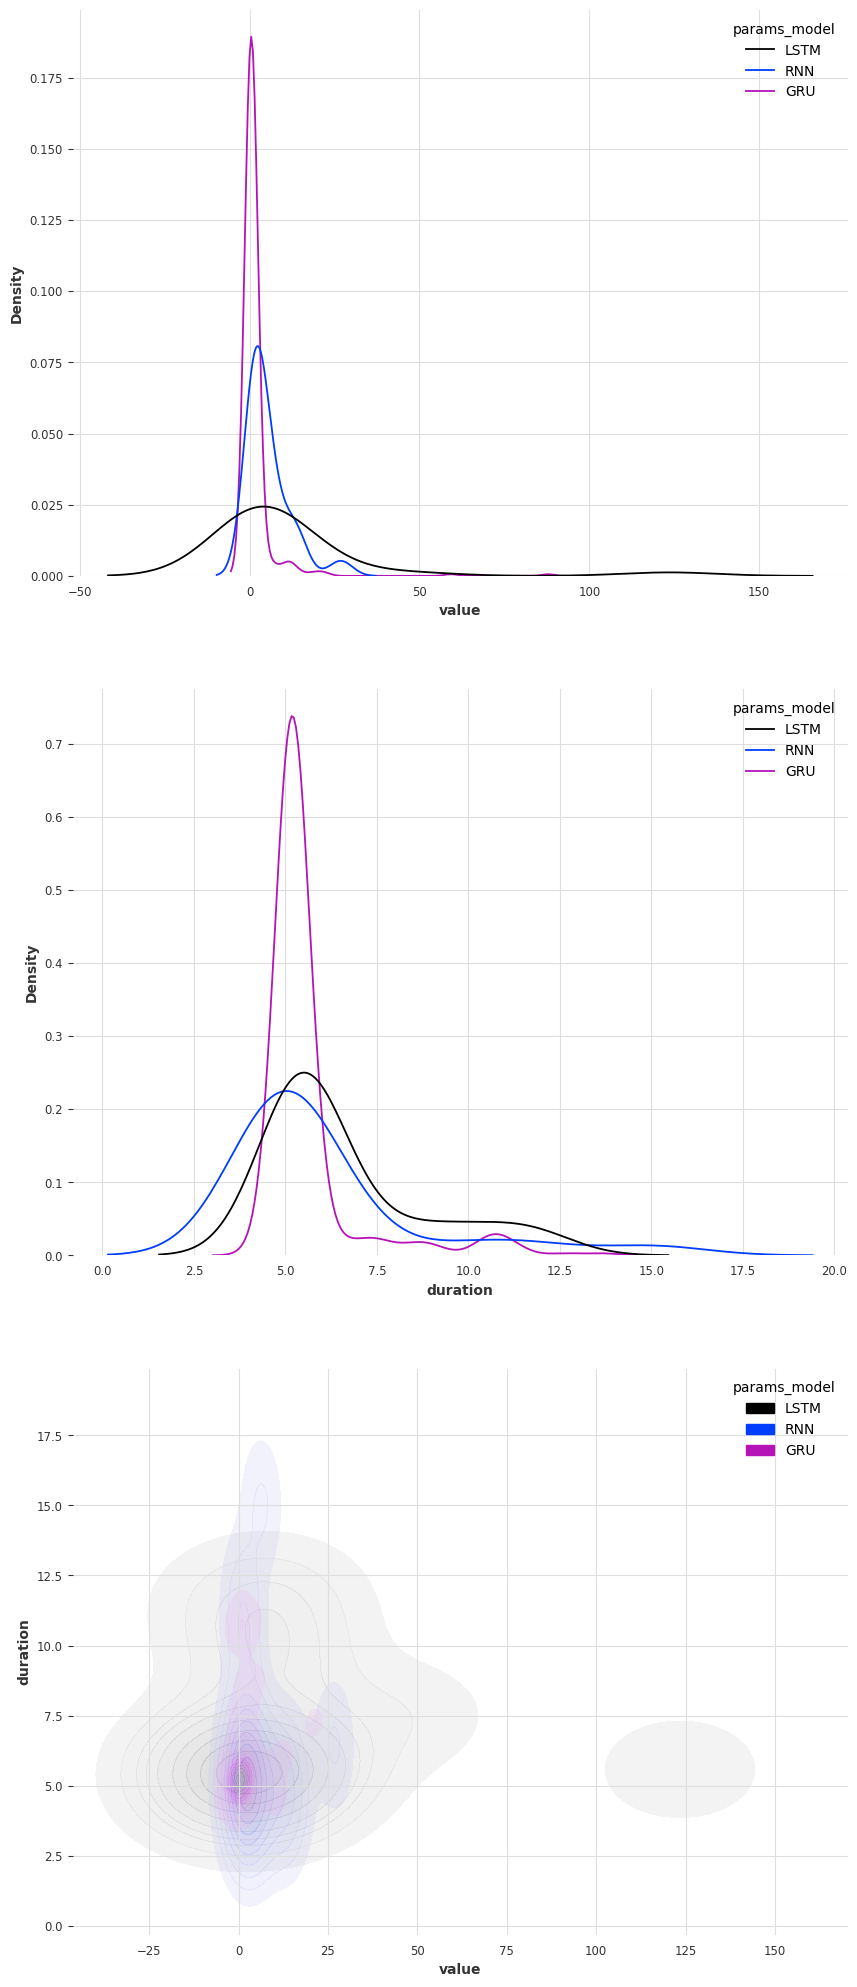

In [61]:
# sns.set(style='dark',)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 25))
sns.kdeplot(study_df, x="value", hue="params_model", ax=ax1, common_norm=False)
sns.kdeplot(study_df, x="duration", hue="params_model", ax=ax2, common_norm=False)
sns.kdeplot(study_df, x="value", y="duration", hue="params_model", ax=ax3, common_norm=False, fill=True, alpha=.2)

plt.show()